In [1]:
import os
os.chdir("../")
print(os.getcwd())

/home/pg221/Desktop/PhD_Projects/Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
torch.cuda.empty_cache()
exp_dir   = "Trained_Models/Exp3.1_Transient_2DCyl_Numobstest_ts13_2_localtest_deactivate_seqmodel"  #Experiment Directory
# exp_name  = "sl32_nhu40_numobs8_bs16_lr5e-5"                #One of the experiment names

models = []
#Non transient data analysis
# exp_name_list = ["sl8_nhu40_numobs2_bs16_lr5e-5_3",\
#                  "sl8_nhu40_numobs3_bs16_lr5e-5_3",\
#                  "sl8_nhu40_numobs4_bs16_lr5e-5_2",\
#                  "sl8_nhu40_numobs8_bs16_lr5e-5_2",\
#                  "sl8_nhu40_numobs16_bs16_lr5e-5_2",\
#                  "sl8_nhu40_numobs32_bs16_lr5e-5"]
exp_name_list = ["sl8_nhu40_numobs32_bs16_lr5e-5_2"]
for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

sl8_nhu40_numobs32_bs16_lr5e-5_2


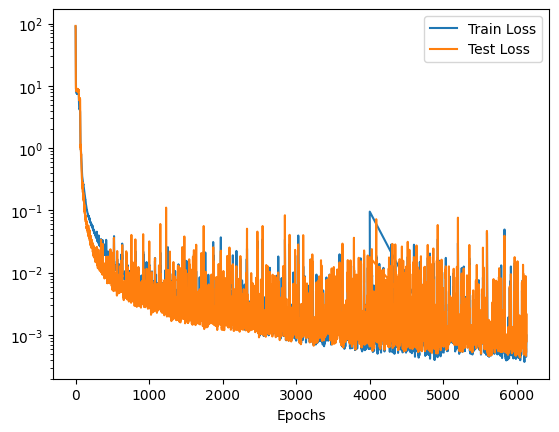

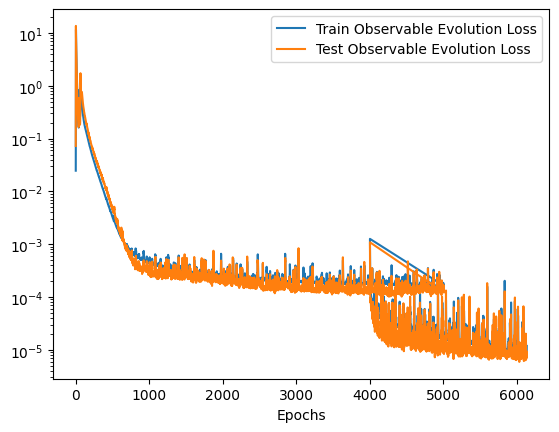

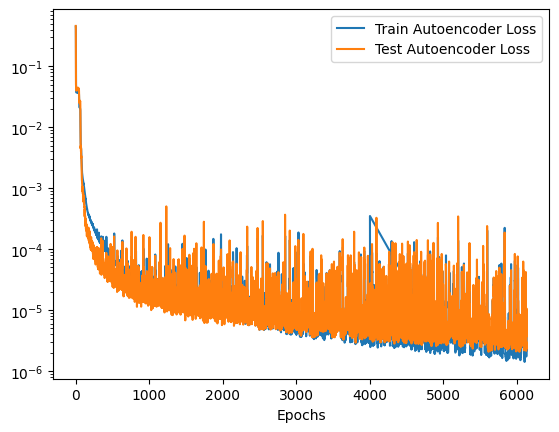

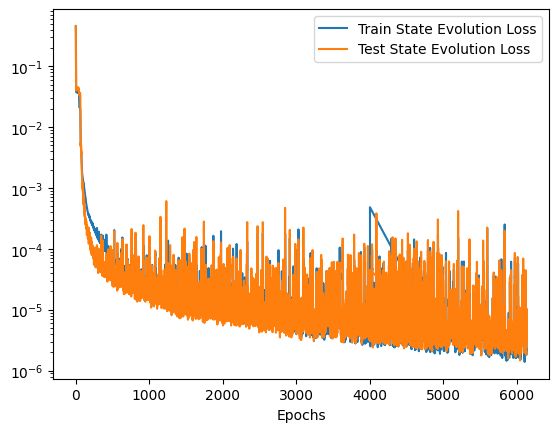

In [4]:
#Sort Models
# def param_find(model):
#     return model.seq_len
# models.sort(key = param_find)

# for model in models:
#     print(model.exp_name)

#plot learning curves
models[0].plot_learning_curves()

In [5]:
#loading weights
# epoch_num = 1700

# #Non Transient data
# for i in range(len(models)):
#     if i==0:
#         epoch_num = 8059
#     elif i == 1:
#         epoch_num = 4999
#     elif i == 7:
#         epoch_num = 2990
#     else:
#         epoch_num = 2990
#     models[i].load_weights(epoch_num)

# Transient Data
for i in range(0,len(models)):
    epoch_num=6000
    models[i].load_weights(epoch_num)

In [6]:
#One Step Prediction

models[-1].load_and_preproc_data()
models[-1].create_dataset(mode = "Train")
dataset = models[-1].train_dataset
num_trajs = models[-1].train_num_trajs
# eval_mza.train_size = 0.9
for i in range(1):#len(models)):
    i=-1
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape


Data Shape:  (1, 271, 7776)
Not normalizing Input
Train_Shape:  (1, 268, 7776)
out of train
torch.Size([1, 268, 32]) torch.Size([1, 268, 7776]) torch.Size([1, 268, 7776])


In [7]:
#Load Data
with open('Data/2DCylinder/nektar_cyl_data_13_2.pkl', 'rb') as f:
    data_dict = pickle.load(f)


In [8]:
sub_X = data_dict["sub_X"]
sub_Y = data_dict["sub_Y"]
U_nn = Phi_nn_hat[...,:int(Phi_nn_hat.shape[-1]/2)].detach().cpu().numpy()
V_nn = Phi_nn_hat[...,int(Phi_nn_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_nn.shape, V_nn.shape, U.shape, V.shape


((1, 268, 3888), (1, 268, 3888), (1, 268, 3888), (1, 268, 3888))

In [9]:
def energy(u,v):
    k = 0.5*(np.mean(u**2,axis=-1) + np.mean(v**2,axis=-1))
    return k

k_pred = energy(U_nn,V_nn)
k = energy(U, V)

(1, 268)


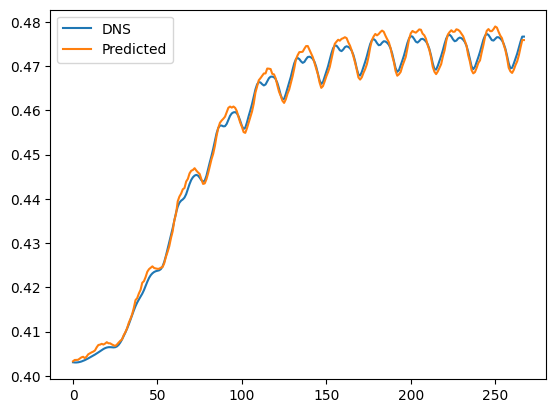

In [10]:
print(k.shape)
plt.plot(k[0,:], label = "DNS")
plt.plot(k_pred[0,:], label = "Predicted")
plt.legend()

In [ ]:
for i in range(100,150):
    plt.figure()
    plt.scatter(sub_X,sub_Y,c=abs((U_nn[0,i]-U[0,i])/U[0,i]), s=1, cmap = 'coolwarm')
    cbar = plt.colorbar()
    # Set the colorbar limits
    cbar.mappable.set_clim(vmin=0, vmax=0.1)
    plt.gca().set_aspect('equal')

    plt.savefig(models[-3].exp_dir + "/" + models[-3].exp_name + "/error_pred/")

# plt.axes().set_aspect('equal')

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "DNS")
    plt.legend()

plt.ylabel("u0")
plt.xlabel("Timesteps")
plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(koop_out.cpu().numpy()[i,:,1], label = "Koopman Predicted")
    plt.plot(seqmodel_out.cpu().numpy()[i,:,1], label = "Seqmodel Predicted")
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,1], label = "DNS")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

In [ ]:
#defining moving average
def moving_avg(u):

    pdu  = pd.DataFrame(u)
    u_ma = pdu.expanding().mean()
    return u_ma

# print(u_ma.shape)

# plt.plot(np.arange(u.shape[1]),u[...,0].squeeze(), label = "Mean Energy")
# plt.plot(u_ma)
# # plt.plot(np.arange(ref_X.shape[0]),ref_X_ma, linewidth = 3, label = "Time Moving Average")
# plt.xlabel("Time Units")
# plt.ylabel("Mean Energy")
# plt.legend()

In [ ]:
Phi_nn_hat_ma = moving_avg(Phi_nn_hat.cpu().numpy())

plt.plot(Phi_nn_hat_ma)

In [11]:
#multistep prediction
timesteps = 200
initial_conditions = Phi_nn[:,0,:].to(models[0].device)

x_hat = []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i] = models[i].predict_multistep(initial_conditions, timesteps)
    x_hat.append(x_hat_temp)
print(Phi_ms_hat.shape)


ic shape: torch.Size([1, 7776])
torch.Size([1, 1, 201, 7776])


In [12]:
U_ms_hat = Phi_ms_hat[...,:int(Phi_ms_hat.shape[-1]/2)].detach().cpu().numpy()
V_ms_hat = Phi_ms_hat[...,int(Phi_ms_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_ms_hat.shape, V_ms_hat.shape, U.shape, V.shape

((1, 1, 201, 3888), (1, 1, 201, 3888), (1, 268, 3888), (1, 268, 3888))

IndexError: index 205 is out of bounds for axis 2 with size 201

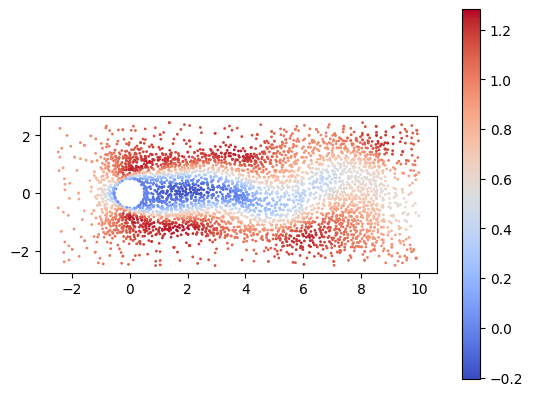

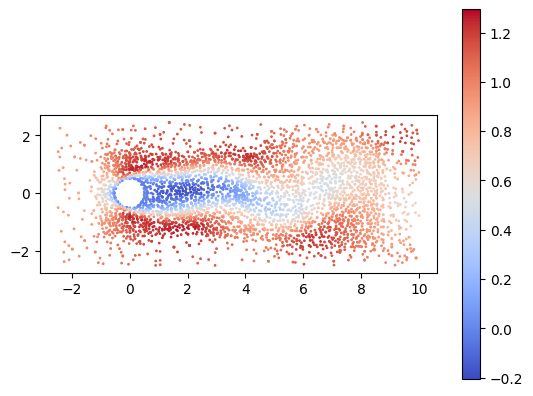

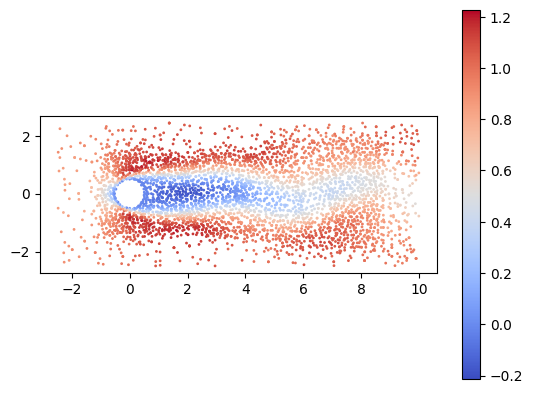

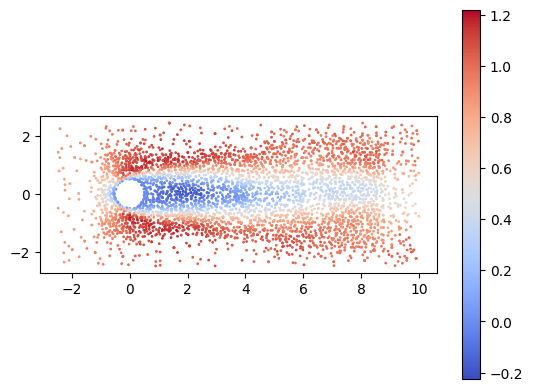

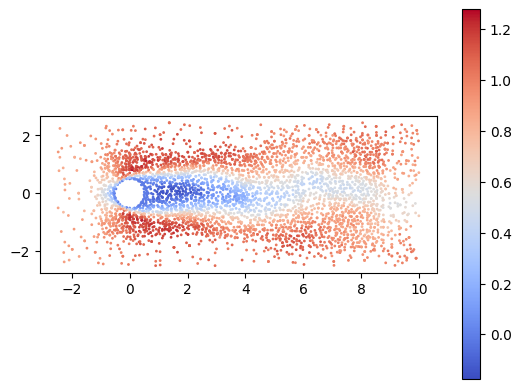

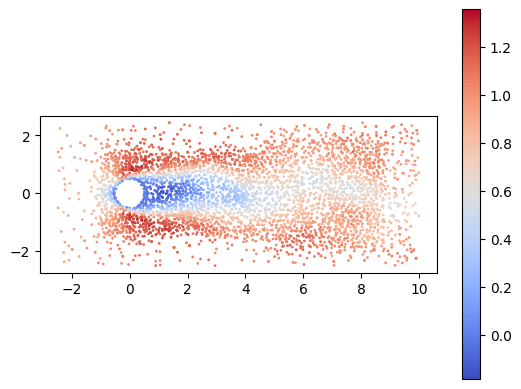

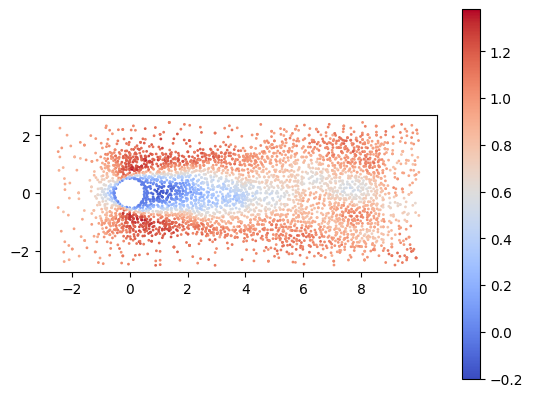

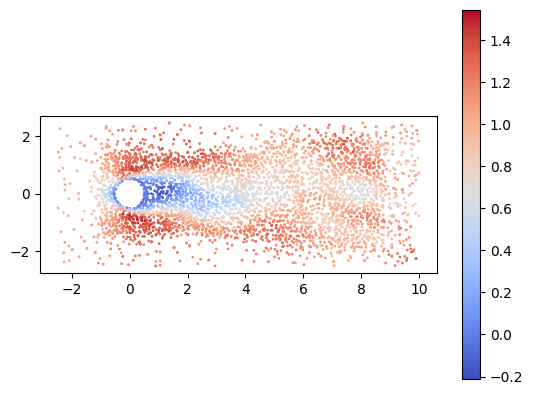

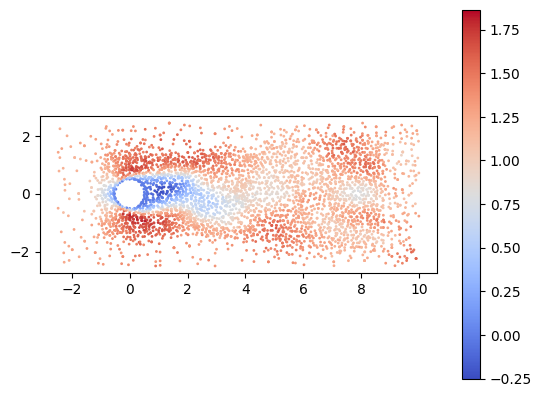

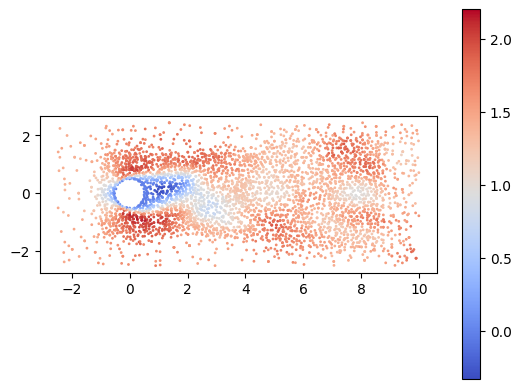

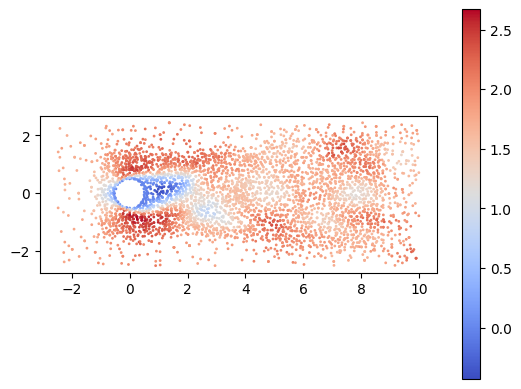

<Figure size 640x480 with 0 Axes>

: 

In [16]:
for i in range (150,250,5):
    plt.figure()
    # plt.scatter(sub_X,sub_Y,c=abs((U_ms_hat[-1,0,i]-U[0,i])/U[0,i]), s=1, cmap = 'coolwarm')
    plt.scatter(sub_X,sub_Y,c = U_ms_hat[0,0,i], s=1, cmap = 'coolwarm')
    cbar = plt.colorbar()
    # Set the colorbar limits
    # cbar.mappable.set_clim(vmin=0, vmax=0.1)
    plt.gca().set_aspect('equal')

    # plt.savefig(models[-1].exp_dir + "/" + models[-1].exp_name + "/out_log/error_plots/fig"+str(i)+".png")

torch.Size([1, 268, 7776]) torch.Size([1, 1, 201, 7776])


Text(0, 0.5, 'MSE')

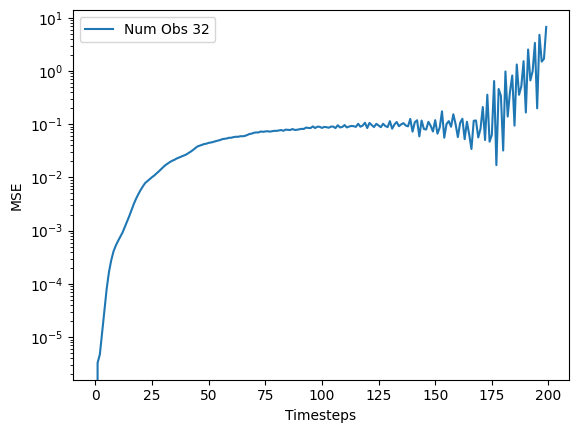

In [15]:
print(Phi_nn.shape, Phi_ms_hat.shape)
State_MSE_multistep = torch.zeros((len(models),timesteps))

plt.figure()
for i in [0]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    # if i!=len(models)-1:
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Num Obs {models[i].num_obs}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

In [ ]:
plt.figure()
for i in range(len(models)):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Number of Observables {models[i].num_obs}")

plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")

In [ ]:
import numpy
k1 = np.load("koopman_numobs4.npy")
k2 = np.load("koopman_numobs16.npy")
k3 = np.load("koopman_numobs32.npy")
k1.shape

plt.figure()
# plt.plot(k1[:,0])
plt.plot(np.linspace(0,101,1001),k2[0,:,1], label = "Koopman")
plt.plot(np.linspace(0,101,1001),Phi_nn[0,:1001,1].cpu().numpy(), label = "Target")
plt.plot(np.linspace(0,101,1001),Phi_hat.cpu().numpy()[0,:,1], label = "MZA Memory = 0.4 timeunits")
# plt.plot(k3[:,0])
plt.legend()
plt.xlabel("Timeunits")
plt.ylabel("u1")
k2.shape

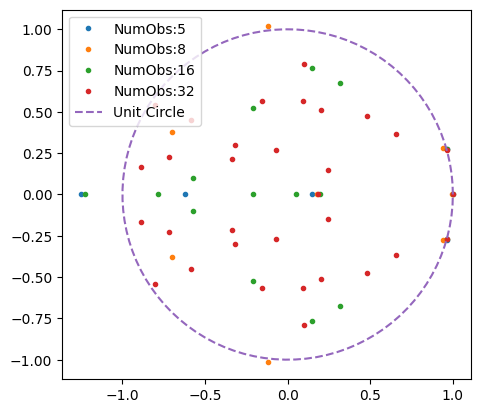

In [24]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')
for i in [1,2,3,4]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    # plt.matshow(mat)
    # plt.colorbar()

    # plt.figure()
    
    plt.plot(np.real(w), np.imag(w), ".", label = f"NumObs:{models[i].num_obs}")

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', label = "Unit Circle")
plt.legend()


In [ ]:
error = np.zeros((1,models[-1].num_obs))
for i in range(error.shape[1]):
    error[0,i] = np.linalg.norm(mat*v[:,i] - w[i]*mat,ord="fro")
print(error)

In [ ]:
#decoding the eigenvectors
print(v.shape)
tv = torch.tensor(np.real(v)).to(models[-2].device)

koopmodes = models[-2].model.autoencoder.recover(tv)
koopmodes.shape

In [ ]:
plt.figure()
plt.scatter(sub_X,sub_Y,c=koopmodes.detach().cpu().numpy()[0,:], s=1, cmap = 'coolwarm')